In [51]:
import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from collections import Counter
from math import log

import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Decision Trees for Classification

Decision trees are a fundamental supervised learning method, especially popular for classification tasks. A decision tree classifies examples by recursively partitioning the feature space: each internal node of the tree applies a test on a feature, and each branch descending from that node corresponds to one of the possible outcomes of the test. The process continues until the leaves of the tree, which assign a class label. The key challenge in building a decision tree is deciding *which feature and threshold to split on at each node* to most effectively separate the classes. To make these decisions, decision tree algorithms use **impurity measures** that quantify how “mixed” the class labels are in a set of training examples. In classification trees, the two most commonly used impurity measures are **entropy** (from information theory) and the **Gini index** (used in the CART algorithm). These measures, and their associated splitting criteria (information gain for entropy and Gini gain for Gini index), guide the recursive partitioning strategy of the tree.

In this lecture, we focus on classification trees and delve into the rigorous definitions of entropy and Gini impurity, how they are used to select splits (maximizing information gain or Gini reduction), and how a decision tree is constructed through recursive partitioning. We will walk through the mathematics of these impurity measures, provide step-by-step pseudocode for the tree-building algorithm, and illustrate the concepts with a worked example (the classic *“Play Tennis”* dataset). Finally, we will compare entropy and Gini in practice, discussing their differences and similarities in decision tree learning.

## Impurity Measures for Classification  

To build an effective decision tree, we need a way to evaluate the quality of a potential split. Intuitively, a *good* split is one that produces child nodes that are as pure as possible in terms of class composition (ideally all instances in a branch belong to the same class). Impurity measures quantify the heterogeneity of classes in a node (a subset of data). Below we introduce two impurity measures: **entropy** (from Shannon’s information theory) and **Gini impurity**. Both are functions of the class probabilities in a node, and both achieve their minimum value (zero) when the node is *pure* (all examples belong to one class).

### Entropy (Information Entropy)  

In the context of decision trees, entropy is a measure of disorder or uncertainty in a node’s class distribution ([Information gain (decision tree) - Wikipedia](https://en.wikipedia.org/wiki/Information_gain_(decision_tree)#:~:text=For%20a%20better%20understanding%20of,and%20the%20information%20value%20increases)) ([Decision tree learning - Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning#:~:text=Entropy%20is%20defined%20as%20below)). Consider a node (or dataset) $T$ containing $N$ examples, which belong to $J$ possible classes. Let $p_i$ be the proportion of examples in $T$ that belong to class $i$ (so $p_i = \frac{\text{count}(i \text{ in } T)}{N}$ for $i=1,2,\dots,J$, and $\sum_{i=1}^J p_i = 1$). The **entropy** $H(T)$ of the node is defined as: 

$$ 
H(T) \;=\; -\sum_{i=1}^{J} p_i \,\log_2 p_i \,,
$$

where the logarithm is base 2, so the unit of entropy is the “bit.” (We use $\;0 \log_2 0 := 0\;$ for terms where $p_i=0$, consistent with $\lim_{p\to0^+} p \log_2 p = 0$.) This formula is the standard Shannon entropy from information theory ([Decision tree learning - Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning#:~:text=Entropy%20is%20defined%20as%20below)). It quantifies the impurity of the node: $H(T)$ is zero if and only if all $p_i$ except one are zero (i.e. the node contains only one class of examples, so there is no uncertainty), and $H(T)$ achieves its maximum when the class distribution is most evenly mixed (the uncertainty is highest). For a binary classification node ($J=2$), entropy ranges from 0 (completely pure) to 1 (maximally impure when classes are 50/50) ([ML | Gini Impurity and Entropy in Decision Tree | GeeksforGeeks](https://www.geeksforgeeks.org/gini-impurity-and-entropy-in-decision-tree-ml/#:~:text=The%20range%20of%20the%20Gini,It%20is%20sensitive%20to%20the)) ([Decision Trees: Gini vs Entropy | Quantdare](https://quantdare.com/decision-trees-gini-vs-entropy/#:~:text=%24%24Entropy_%7Bmin%7D%20%3D%20,0)). For example, if a node has 40% positive examples and 60% negative examples, its entropy is: 

$$
H = - (0.4 \log_2 0.4 \;+\; 0.6 \log_2 0.6) \approx 0.970 \text{ bits}.
$$

Entropy can be interpreted as the **amount of information needed to specify the class of a random example from the node** ([ML | Gini Impurity and Entropy in Decision Tree | GeeksforGeeks](https://www.geeksforgeeks.org/gini-impurity-and-entropy-in-decision-tree-ml/#:~:text=the%20number%20of%20classes,the%20class%20of%20an%20instance)). Higher entropy means the data in the node are more mixed and uncertain (requiring more information to describe the class), whereas lower entropy means the node is more pure (less information is needed). In decision tree learning, entropy serves as a criterion to decide splits: we prefer splits that **reduce entropy**, because a big drop in entropy means the child nodes are more homogeneous than the parent. This reduction in entropy is precisely the **information gain**, which we will formalize shortly.

### Gini Impurity (Gini Index)  

Another popular impurity measure for classification trees is the Gini impurity (also called the Gini index or Gini diversity index) ([Decision tree learning - Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning#:~:text=Gini%20impurity%2C%20Gini%27s%20diversity%20index%2C,into%20a%20single%20target%20category)). For a node $T$ with class proportions $p_1, p_2, \dots, p_J$ defined as before, the **Gini impurity** $I_G(T)$ is defined as: 

$$ 
I_G(T) \;=\; \sum_{i=1}^{J} p_i(1 - p_i) \;=\; 1 - \sum_{i=1}^{J} p_i^2 \,. 
$$

This simplified form $1 - \sum p_i^2$ is obtained by noting that 

$$\sum_{i} p_i(1-p_i) = \sum_{i} (p_i - p_i^2) = \sum_i p_i - \sum_i p_i^2 = 1 - \sum_i p_i^2$$ 

(since $\sum_i p_i = 1$) ([Decision tree learning - Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning#:~:text=Image%3A%20,sum%20_%7Bi%3D1%7D%5E%7BJ%7Dp_%7Bi%7D%5E%7B2)). The Gini impurity can be understood as the expected misclassification rate if we randomly labeled an example according to the class distribution in the node ([Decision tree learning - Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning#:~:text=Gini%20impurity%2C%20Gini%27s%20diversity%20index%2C,into%20a%20single%20target%20category)). Like entropy, Gini impurity is zero when the node is pure (one of the $p_i=1$ and the rest 0, giving $I_G=0$), and it reaches its maximum when the classes are uniformly mixed. For binary classification, $I_G$ ranges from 0 to 0.5 (maximum impurity occurs at a 50/50 split, where $I_G = 1 - (0.5^2+0.5^2) = 0.5$) ([Decision Trees: Gini vs Entropy | Quantdare](https://quantdare.com/decision-trees-gini-vs-entropy/#:~:text=The%20minimum%20value%20of%20the,two%20classes%20are%20the%20same)). For example, for the same node with 40% vs 60% class distribution, the Gini impurity would be: 

$$
I_G = 1 - (0.4^2 + 0.6^2) = 1 - (0.16 + 0.36) = 0.48\,.
$$

Comparing entropy and Gini impurity, both measures attain their extrema under the same conditions (minimum 0 when pure, maximum when classes are equally mixed). The curves of entropy and Gini (for binary nodes) are qualitatively similar, with entropy (in base 2) being 0 to 1 and Gini 0 to 0.5 over the range of class probabilities ([Decision Trees: Gini vs Entropy | Quantdare](https://quantdare.com/decision-trees-gini-vs-entropy/#:~:text=,which%20are%20not%20very%20significant)). One notable difference is that Gini is a *quadratic* measure (it involves squaring the probabilities) whereas entropy is *logarithmic*. As a result, the entropy grows a bit faster near extreme probabilities, meaning it penalizes extreme class imbalance slightly more heavily than Gini. Nonetheless, in practice the two criteria often agree on the best split, as we will discuss later. 

**Justification of the Gini formula:** It’s instructive to see why $I_G = \sum_i p_i(1-p_i)$ represents the expected misclassification rate. If we randomly pick an instance from the node and then randomly assign a class label according to the node’s class distribution, the probability that we *mislabel* that instance is 1 minus the probability we correctly label it. The probability of correctly labeling it by chance is $\sum_i p_i \cdot p_i$ (since with probability $p_i$ the instance is of class $i$, and we assign class $i$ with probability $p_i$ as well), which is $\sum_i p_i^2$. Therefore the misclassification probability is $1 - \sum_i p_i^2$, which is exactly $I_G(T)$. This aligns with the interpretation that Gini impurity measures how often an example would be misclassified if we made random guesses according to the class probabilities ([Decision tree learning - Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning#:~:text=Gini%20impurity%2C%20Gini%27s%20diversity%20index%2C,into%20a%20single%20target%20category)). 

In summary, **low values of entropy or Gini indicate an *informative* (pure) node**, whereas high values indicate a *disordered* (impure) node. Decision tree algorithms seek splits that transition from higher impurity (before splitting) to lower impurity (after splitting), thereby increasing the overall purity of the partitions.

## Selecting the Best Split: Information Gain and Gini Gain  

Now that we have defined our impurity measures, how do we use them to pick an optimal split at a node? The typical strategy is to consider all candidate splits (e.g. for each feature, and for each possible value or threshold of that feature) and compute how much the impurity would be reduced if that split were applied. We then choose the split that yields the largest impurity reduction. 

- When using **entropy** as the impurity measure, the criterion is called **information gain**. It is defined as the drop in entropy due to the split ([Information gain (decision tree) - Wikipedia](https://en.wikipedia.org/wiki/Information_gain_(decision_tree)#:~:text=Gain%20%3D%20,2)) ([Information gain (decision tree) - Wikipedia](https://en.wikipedia.org/wiki/Information_gain_(decision_tree)#:~:text=Image%3A%20%7B%5Cdisplaystyle%20IG%28T%2Ca%29%3D%5Cmathrm%20%7BH%7D%20%28T%29,%28T%7Ca)). If node $T$ (the parent node) has entropy $H(T)$ and a split of $T$ into child nodes $T_1, T_2, \dots, T_k$ (for example, $k$ could be the number of branches if splitting on a categorical feature, or $k=2$ for a binary split) results in those child subsets, then the information gain $IG$ of that split is: 

  $$
  IG = H(T)\;-\; \sum_{j=1}^{k} \frac{|T_j|}{|T|} \, H(T_j) \,,
  $$

  where $|T_j|/|T|$ is the fraction of examples that go into child $j$. This is equivalent to $IG(T, \text{feature}) = H(T) - H(T \mid \text{feature})$, i.e. the unconditional entropy minus the conditional entropy after observing the feature ([Information gain (decision tree) - Wikipedia](https://en.wikipedia.org/wiki/Information_gain_(decision_tree)#:~:text=inputs%20of%20T%20for%20which,T%7Ca)) ([Information gain (decision tree) - Wikipedia](https://en.wikipedia.org/wiki/Information_gain_(decision_tree)#:~:text=difference%20between%20the%20unconditional%20Shannon,mathrm%20%7BH%7D%20%7B%28T%7Ca%29%7D.%5Cend%7Balignedat)). The larger the information gain, the more the feature contributes to reducing uncertainty about the class label ([Information gain (decision tree) - Wikipedia](https://en.wikipedia.org/wiki/Information_gain_(decision_tree)#:~:text=For%20a%20better%20understanding%20of,and%20the%20information%20value%20increases)). A perfect split (one that produces completely pure children) would have an information gain equal to the parent entropy (since the child entropies would be 0). In practice, we choose the feature and threshold that maximize this $IG$.

- When using **Gini impurity**, an analogous criterion is the **Gini gain**, which is the reduction in Gini impurity from parent to children. If $I_G(\text{parent})$ is the Gini of the parent node and the split yields children $T_1, \dots, T_k$ with Gini values $I_G(T_j)$, then:

  $$
  \Delta Gini = I_G(\text{parent}) \;-\; \sum_{j=1}^{k} \frac{|T_j|}{|T|}\, I_G(T_j) \,. 
  $$

  Decision tree algorithms that use the Gini criterion (such as CART) will choose the split that maximizes this Gini gain (equivalently, minimizes the weighted Gini of the children) ([Decision Trees: Gini vs Entropy | Quantdare](https://quantdare.com/decision-trees-gini-vs-entropy/#:~:text=The%20gini%20impurity%20measures%20the,when%20it%20is%20randomly%20labeled)). Again, a perfect purifying split would achieve the maximum possible $\Delta Gini$ equal to the parent’s $I_G$.

In summary, both criteria evaluate splits by a **weighted average impurity of the child nodes** and prefer the split that produces the largest reduction in impurity. This is a greedy, locally optimal decision at each node. For example, the original ID3 algorithm by Quinlan uses information gain (entropy) to choose splits, while CART (Classification and Regression Trees by Breiman *et al.*) uses the Gini index ([ML | Gini Impurity and Entropy in Decision Tree | GeeksforGeeks](https://www.geeksforgeeks.org/gini-impurity-and-entropy-in-decision-tree-ml/#:~:text=higher%20reduction%20of%20uncertainty,5%20algorithms)) ([Decision tree learning - Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning#:~:text=Gini%20impurity%2C%20Gini%27s%20diversity%20index%2C,into%20a%20single%20target%20category)). Modern implementations (such as scikit-learn’s DecisionTreeClassifier) often allow the user to choose either `"entropy"` or `"gini"` as the `criterion` for splitting ([Decision Trees: Gini vs Entropy | Quantdare](https://quantdare.com/decision-trees-gini-vs-entropy/#:~:text=split%20of%20the%20features,choose%20between%20%E2%80%98gini%E2%80%98%20or%20%E2%80%98entropy%E2%80%98)), since both are valid measures of node quality.

It is worth noting that there are other splitting criteria as well (for instance, **classification error rate** $= 1 - \max_i p_i$ can be used as an impurity measure, or **Gain Ratio** which is an information gain normalized by split entropy as used in C4.5 to penalize splits with many outcomes). However, entropy and Gini are by far the most widely used, and they usually lead to very similar trees in practice. The choice between them can be based on practical considerations: Gini is somewhat faster to compute (no logarithms) ([Decision Trees: Gini vs Entropy | Quantdare](https://quantdare.com/decision-trees-gini-vs-entropy/#:~:text=Image%3A%20Representation%20of%20Gini%20Index,and%20EntropyGini%20Index%20and%20Entropy)), while entropy/information gain has an information-theoretic interpretation and sometimes a slight edge in accuracy ([Decision Trees: Gini vs Entropy | Quantdare](https://quantdare.com/decision-trees-gini-vs-entropy/#:~:text=On%20the%20one%20hand%2C%20the,it%20is%20less%20computationally%20expensive)). In most scenarios, the difference is not significant, and either criterion will yield a good tree.

## Recursive Partitioning Algorithm for Decision Trees  

Using the concepts of information gain or Gini gain, a decision tree is built by a recursive partitioning procedure. The algorithm starts with the entire training dataset at the root and then applies the following recursive strategy:

1. **If all training examples in the current node belong to the same class,** then the node is made a **leaf** with that class label (no further splitting is needed, since the node is pure). Likewise, if there are no remaining features to split on (or other stopping criteria are met, such as reaching a minimum node size), then we also stop and make the node a leaf, labeling it with the majority class in that node.

2. **Otherwise, if the node is impure,** we choose the **best feature** (and threshold, if applicable) to split the node, using the impurity-based criteria described above. That is, for each candidate feature, we evaluate the resulting child nodes’ impurity (using entropy or Gini) and compute the information gain (or Gini reduction). We select the feature that yields the highest gain.

3. **Split the node** on the chosen feature. This creates two or more child nodes (one for each distinct value range of the feature split). Each child node receives the subset of training examples that have the corresponding feature value (or fall into the threshold range for numeric features).

4. **Recurse** on each child node, treating the subset of data in that node as the new input dataset and the remaining features as candidates for further splits. The same process repeats: if a child node is pure (or other stopping condition triggers), it becomes a leaf; otherwise, we find the best split for it, and continue growing the tree.

This procedure naturally yields a tree structure through a *divide-and-conquer* approach. It is a greedy algorithm — at each node, the decision is made based on local impurity reduction. While this greedy approach doesn’t guarantee a globally optimal tree (finding the optimal decision tree is an NP-hard problem), it tends to produce a good solution in practice, especially when combined with techniques like pruning to avoid overfitting.


## Worked Example: Building a Decision Tree (ID3) on the *Play Tennis* Dataset  

To ground the concepts in a concrete example, let’s walk through the construction of a decision tree using the classic **Play Tennis** dataset. This dataset (from Tom Mitchell’s *Machine Learning* book) contains 14 examples of days, each described by weather conditions, and a target label indicating whether tennis was played on that day. The features are: **Outlook** (Sunny, Overcast, or Rain), **Temperature** (Hot, Mild, Cool), **Humidity** (High or Normal), and **Wind** (Weak or Strong). The target is **PlayTennis** (Yes or No). A few sample records from this dataset are shown below:

In [61]:
Data = pd.DataFrame({
       'Outlook': ['sunny', 'sunny', 'overcast', 'rainy', 'rainy', 'rainy', 
                   'overcast', 'sunny', 'sunny', 'rainy', 'sunny', 'overcast',
                   'overcast', 'rainy'],
       'Temperature': ['hot', 'hot', 'hot', 'mild', 'cool', 'cool', 'cool',
                       'mild', 'cool', 'mild', 'mild', 'mild', 'hot', 'mild'],
       'Humidity': ['high', 'high', 'high', 'high', 'normal', 'normal', 'normal',
                    'high', 'normal', 'normal', 'normal', 'high', 'normal', 'high'],
       'Windy': ['false', 'true', 'false', 'false', 'false', 'true', 'true',
                 'false', 'false', 'false', 'true', 'true', 'false', 'true'],
       'Play': ['no', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 
                            'yes','yes','yes','no']})

Data

,Outlook,Temperature,Humidity,Windy,Play
0,sunny,hot,high,false,no
1,sunny,hot,high,true,no
2,overcast,hot,high,false,yes
3,rainy,mild,high,false,yes
4,rainy,cool,normal,false,yes
5,rainy,cool,normal,true,no
6,overcast,cool,normal,true,yes
7,sunny,mild,high,false,no
8,sunny,cool,normal,false,yes
9,rainy,mild,normal,false,yes


### Step 1 (Root Node)

Compute the entropy of the target in the full dataset (before any split). There are 9 Yes and 5 No, so $p(\text{Yes})=9/14 \approx 0.643$ and $p(\text{No})=5/14 \approx 0.357$. The entropy of the root node is: 

  $$H_{\text{root}} = -\,(0.643 \log_2 0.643 \;+\; 0.357 \log_2 0.357) \approx 0.940\text{ bits}$$ 

(The calculation gives $H \approx 0.940$ ([A Tutorial to Understand Decision Tree ID3 Learning Algorithm – The Null Pointer Exception](https://nulpointerexception.com/2017/12/16/a-tutorial-to-understand-decision-tree-id3-learning-algorithm/#:~:text=%3E%20Entropy%20at%20source%3D%20,log2%280.357%29%20%3E%20%3E%20%3D0.940)).) This is the impurity of the unsplit dataset. Now we evaluate possible splits by each feature:

#### Outlook:
Outlook can take three values (Sunny, Overcast, Rain). We partition the 14 days into these groups and compute their entropies:

- *Sunny:* There are 5 days with Outlook = Sunny. Among these, PlayTennis was Yes on 2 days and No on 3 days (2 Yes, 3 No) ([A Tutorial to Understand Decision Tree ID3 Learning Algorithm – The Null Pointer Exception](https://nulpointerexception.com/2017/12/16/a-tutorial-to-understand-decision-tree-id3-learning-algorithm/#:~:text=1,What%20is%20the%20entropy%20here)). The entropy for the Sunny subset is 
      $$H(\text{Sunny}) = -\,(2/5 \log_2(2/5) + 3/5 \log_2(3/5)) \approx 0.971.$$
- *Overcast:* There are 4 days with Outlook = Overcast. All 4 of those days have PlayTennis = Yes (4 Yes, 0 No) ([A Tutorial to Understand Decision Tree ID3 Learning Algorithm – The Null Pointer Exception](https://nulpointerexception.com/2017/12/16/a-tutorial-to-understand-decision-tree-id3-learning-algorithm/#:~:text=2,Let)). This subset is pure, so its entropy is 
      $$H(\text{Overcast}) = -\,(1 \log_2 1 + 0 \log_2 0) = 0.$$
- *Rain:* There are 5 days with Outlook = Rain. Among these, PlayTennis was Yes on 3 days and No on 2 days (3 Yes, 2 No) ([A Tutorial to Understand Decision Tree ID3 Learning Algorithm – The Null Pointer Exception](https://nulpointerexception.com/2017/12/16/a-tutorial-to-understand-decision-tree-id3-learning-algorithm/#:~:text=,%3D%200.97)). The entropy for the Rain subset is 
      $$H(\text{Rain}) = -\,(3/5 \log_2(3/5) + 2/5 \log_2(2/5)) \approx 0.971,$$ 
which interestingly is the same as for Sunny (the distributions 2/5 vs 3/5 and 3/5 vs 2/5 give the same entropy).
    
Now, the weighted average entropy if we split on Outlook is: 

$$H_{\text{after split}} = \frac{5}{14}H(\text{Sunny}) + \frac{4}{14}H(\text{Overcast}) + \frac{5}{14}H(\text{Rain})$$ 
$$= \frac{5}{14}(0.971) + \frac{4}{14}(0.0) + \frac{5}{14}(0.971) \approx 0.693.$$

So, the **information gain from splitting on Outlook** is the entropy before split minus this entropy after split: 

$$IG(\text{Outlook}) = 0.940 - 0.693 = 0.247 \text{ bits (approximately).}$$ 

We have achieved a significant reduction in entropy by splitting on Outlook (from 0.94 down to 0.693) ([A Tutorial to Understand Decision Tree ID3 Learning Algorithm – The Null Pointer Exception](https://nulpointerexception.com/2017/12/16/a-tutorial-to-understand-decision-tree-id3-learning-algorithm/#:~:text=What%20is%20the%20reduction%20is,outlook%20as%20a%20decsion%20maker)).

#### Temperature:
Temperature has values Hot, Mild, Cool. We would do a similar calculation for the subsets of days that are Hot, Mild, and Cool. Without going through all numbers, the result (from the dataset) is that the weighted entropy after splitting by Temperature is about 0.910, yielding an information gain of only $0.940 - 0.910 = 0.029$ bits ([A Tutorial to Understand Decision Tree ID3 Learning Algorithm – The Null Pointer Exception](https://nulpointerexception.com/2017/12/16/a-tutorial-to-understand-decision-tree-id3-learning-algorithm/#:~:text=Information%20Gain%20%3D%200)). So Temperature is not a very informative feature at the root.

- **Humidity:** Humidity has two values: High or Normal. Among the 14 days, 7 have High humidity (out of which 3 are Yes and 4 are No), and 7 have Normal humidity (out of which 6 are Yes and 1 is No). The entropy for the High subset and Normal subset can be calculated, and the weighted entropy after the split is around 0.788, giving an information gain of $0.940 - 0.788 = 0.152$ bits ([A Tutorial to Understand Decision Tree ID3 Learning Algorithm – The Null Pointer Exception](https://nulpointerexception.com/2017/12/16/a-tutorial-to-understand-decision-tree-id3-learning-algorithm/#:~:text=Humidity)).

- **Wind:** Wind has two values: true or false. In the data, there are 8 no wind days (6 Yes, 2 No) and 6 windy days (3 Yes, 3 No). Splitting by Wind yields a weighted entropy of about 0.892, for an information gain of $0.940 - 0.892 = 0.048$ bits ([A Tutorial to Understand Decision Tree ID3 Learning Algorithm – The Null Pointer Exception](https://nulpointerexception.com/2017/12/16/a-tutorial-to-understand-decision-tree-id3-learning-algorithm/#:~:text=match%20at%20L226%20Information%20Gain,048)).

Comparing the information gains: Outlook gives approx. 0.247, Humidity approx. 0.152, Wind approx. 0.048, Temperature approx. 0.029. **Outlook has the highest information gain** ([A Tutorial to Understand Decision Tree ID3 Learning Algorithm – The Null Pointer Exception](https://nulpointerexception.com/2017/12/16/a-tutorial-to-understand-decision-tree-id3-learning-algorithm/#:~:text=Information%20Gain%20%3D%200)), so the root node will use Outlook as the splitting feature. This makes sense: knowing the Outlook (Sunny, Overcast, Rain) gives the most information about whether tennis will be played, according to this data.

In [62]:
def H(x):
    tmp = Counter(x)
    vs = tmp.values()
    N = len(x)
    return sum([-log(v,2)*v/N for v in vs])+log(N,2)

def splitByValue(xs,ys):
    zs = np.unique(xs)
    tmp = {z: ys[xs==z] for z in zs}
    return {z: {'counts': dict(Counter(tmp[z])), 
                'entropy': H(tmp[z])} for z in zs}

In [63]:
splitByValue(Data['Outlook'],Data['Play'])
splitByValue(Data['Temperature'],Data['Play'])
splitByValue(Data['Humidity'],Data['Play'])
splitByValue(Data['Windy'],Data['Play'])

{'overcast': {'counts': {'yes': 4}, 'entropy': 0.0},
 'rainy': {'counts': {'yes': 3, 'no': 2}, 'entropy': 0.9709505944546684},
 'sunny': {'counts': {'no': 3, 'yes': 2}, 'entropy': 0.9709505944546684}}

{'cool': {'counts': {'yes': 3, 'no': 1}, 'entropy': 0.8112781244591327},
 'hot': {'counts': {'no': 2, 'yes': 2}, 'entropy': 1.0},
 'mild': {'counts': {'yes': 4, 'no': 2}, 'entropy': 0.9182958340544896}}

{'high': {'counts': {'no': 4, 'yes': 3}, 'entropy': 0.9852281360342516},
 'normal': {'counts': {'yes': 6, 'no': 1}, 'entropy': 0.5916727785823275}}

{'false': {'counts': {'no': 2, 'yes': 6}, 'entropy': 0.8112781244591329},
 'true': {'counts': {'no': 3, 'yes': 3}, 'entropy': 0.9999999999999998}}

### Step 2 (First Split):

We split the root by **Outlook**, creating three branches. After the split:
  
- The **Overcast** branch is a subset of 4 examples all labeled Yes. This node has entropy 0 and is *pure*. In the decision tree, we can immediately mark this branch as a **leaf** with the class **Yes** (if Outlook is Overcast, the tree predicts PlayTennis = Yes). We do not need to split further on this branch.
- The **Sunny** branch is a subset of 5 examples (Outlook=Sunny) with 2 Yes and 3 No, which is impure (entropy ~0.971). We need to continue splitting this subset. The remaining features we can use for splitting are Temperature, Humidity, and Wind (since we don’t typically reuse Outlook after splitting on it, in algorithms like ID3).
- The **Rain** branch is a subset of 5 examples (Outlook=Rain) with 3 Yes and 2 No (entropy ~0.971), also impure and requiring further splitting. Remaining features: Temperature, Humidity, Wind.

In [64]:
overcast = Data[Data['Outlook']=='overcast']
overcast

,Outlook,Temperature,Humidity,Windy,Play
2,overcast,hot,high,false,yes
6,overcast,cool,normal,true,yes
11,overcast,mild,high,true,yes
12,overcast,hot,normal,false,yes


In [65]:
sunny = Data[Data['Outlook']=='sunny']
sunny

,Outlook,Temperature,Humidity,Windy,Play
0,sunny,hot,high,false,no
1,sunny,hot,high,true,no
7,sunny,mild,high,false,no
8,sunny,cool,normal,false,yes
10,sunny,mild,normal,true,yes


In [66]:
rainy = Data[Data['Outlook']=='rainy']
rainy

,Outlook,Temperature,Humidity,Windy,Play
3,rainy,mild,high,false,yes
4,rainy,cool,normal,false,yes
5,rainy,cool,normal,true,no
9,rainy,mild,normal,false,yes
13,rainy,mild,high,true,no


### Step 3 (Splitting the Sunny subset):

We now treat the Sunny subset (5 examples) as our new dataset and find the best feature to split it. The class distribution here is 2 Yes, 3 No. We compute information gain for the remaining features within this subset:

- **Humidity** on Sunny subset: In the Sunny subset, 3 days had High humidity and 2 had Normal humidity. If we split Sunny-days by Humidity:
    - Sunny & High: 3 examples, all 3 of which were No (because in the original data, all Sunny days with High humidity resulted in No). Entropy = 0 (pure subset).
    - Sunny & Normal: 2 examples, both were Yes (Sunny with Normal humidity yielded Yes). Entropy = 0 (pure subset).
    After this split, both child nodes are pure. The weighted entropy would be 0, so the information gain for Humidity in the Sunny subset is the entropy of the Sunny subset (0.971) minus 0, i.e. **0.971**. This is a very high gain (indeed a perfect classification of the Sunny subset).

- **Wind** on Sunny subset: Among Sunny days, if we split by Wind (False vs True):
    - Sunny & Wind=False: 3 examples (1 yes, 2 no)
    - Sunny & Wind=True: 2 examples (1 yes 1 no) It turns out this split does not cleanly separate the classes (some Sunny-False days were Yes, some No; similar for Sunny-True).
    The information gain from Wind would be smaller than from Humidity in this subset. (We won’t calculate it exactly here since we already see Humidity gave a perfect separation).

- **Temperature** on Sunny subset: Sunny days might be Hot or Mild or Cool. Likely this won’t perfectly separate Yes/No either (for instance, in the 5 Sunny days, there might be a mix of Yes/No across temperatures).

Clearly, **Humidity is the best split for the Sunny branch**, as it yields a perfect classification of those examples (all Sunny & High become No, all Sunny & Normal become Yes). So we add a decision node: for the Sunny branch, we test **Humidity** next. This creates two child leaves:
  - If Outlook = Sunny **and** Humidity = High, then **PlayTennis = No** (leaf node).
  - If Outlook = Sunny **and** Humidity = Normal, then **PlayTennis = Yes** (leaf node).
  After this, the Sunny branch is fully processed (no further splitting needed, as both resulting leaves are pure).

In [67]:
splitByValue(sunny['Humidity'],sunny['Play'])
splitByValue(sunny['Windy'],sunny['Play'])
splitByValue(sunny['Temperature'],sunny['Play'])

{'high': {'counts': {'no': 3}, 'entropy': 0.0},
 'normal': {'counts': {'yes': 2}, 'entropy': 0.0}}

{'false': {'counts': {'no': 2, 'yes': 1}, 'entropy': 0.9182958340544897},
 'true': {'counts': {'no': 1, 'yes': 1}, 'entropy': 1.0}}

{'cool': {'counts': {'yes': 1}, 'entropy': 0.0},
 'hot': {'counts': {'no': 2}, 'entropy': 0.0},
 'mild': {'counts': {'no': 1, 'yes': 1}, 'entropy': 1.0}}

### Step 4 (Splitting the Rain subset):

Now consider the Rain subset (5 examples, 3 Yes, 2 No). We check the remaining features (Temperature, Humidity, Wind) for splitting in the Rain branch:

- **Wind** on Rain subset: In those 5 Rain examples, suppose we examine Wind:

- Rain & Wind=True: Looking at the data, the rainy days with strong wind – say there are 2 such days – what are their classes? In the original dataset, “Rain & Wind=True” happened on Day 6 and Day 14 (both resulted in PlayTennis = No). So in this subset, Rain+True gives 2 examples, both No (pure subset, entropy 0).

- Rain & Wind=False: The other rainy days (Day 4, 5, 10) had weak wind and all those resulted in PlayTennis = Yes. So Rain+False gives 3 examples, all Yes (entropy 0).


Thus, splitting on Wind perfectly separates the Rain subset: one child is all No, the other all Yes. Information gain for Wind in this subset would be the entropy of the Rain subset (~0.971) minus 0 = 0.971.

- **Humidity** on Rain subset: Let’s say among the rainy days, some had High humidity (some Yes, some No) and others Normal humidity (also mixed). Indeed, in the data Rain & High humidity occurs on Day 4 (Yes) and Day 14 (No) – mixed outcome; Rain & Normal on Day 5 (Yes), Day 6 (No), Day 10 (Yes) – also mixed. So a Humidity split in the Rain subset would not yield pure children; its information gain would be lower than that of Wind.

- **Temperature** on Rain subset: Rainy days might be Mild or Cool in temperature; those also won’t correlate perfectly with Yes/No in this subset (likely mixed outcomes as well).

So **Wind is the best split for the Rain branch**. We add a decision node: for Outlook = Rain, we test **Wind**. This yields:
  - If Outlook = Rain **and** Wind = True, then **PlayTennis = No** (leaf).
  - If Outlook = Rain **and** Wind = False, then **PlayTennis = Yes** (leaf).

In [68]:
splitByValue(rainy['Humidity'],rainy['Play'])
splitByValue(rainy['Windy'],rainy['Play'])
splitByValue(rainy['Temperature'],rainy['Play'])

{'high': {'counts': {'yes': 1, 'no': 1}, 'entropy': 1.0},
 'normal': {'counts': {'yes': 2, 'no': 1}, 'entropy': 0.9182958340544897}}

{'false': {'counts': {'yes': 3}, 'entropy': 0.0},
 'true': {'counts': {'no': 2}, 'entropy': 0.0}}

{'cool': {'counts': {'yes': 1, 'no': 1}, 'entropy': 1.0},
 'mild': {'counts': {'yes': 2, 'no': 1}, 'entropy': 0.9182958340544897}}

Now we have fully split all branches. Every path from the root leads to a leaf with a class decision:
- Outlook = Overcast → (leaf: Yes).
- Outlook = Sunny AND Humidity = High → (leaf: No).
- Outlook = Sunny AND Humidity = Normal → (leaf: Yes).
- Outlook = Rain AND Wind = Strong → (leaf: No).
- Outlook = Rain AND Wind = Weak → (leaf: Yes).

All 14 training examples are correctly classified by this tree (as expected, since ID3 will continue splitting until pure if no stopping rule is imposed). The final decision tree can be visualized as follows:

DecisionTreeClassifier(criterion='entropy', max_depth=2)

<Figure size 960x720 with 0 Axes>

[Text(0.6, 0.8333333333333334, 'Outlook_overcast <= 0.5\nentropy = 0.94\nsamples = 14\nvalue = [5, 9]\nclass = yes'),
 Text(0.4, 0.5, 'Humidity_high <= 0.5\nentropy = 1.0\nsamples = 10\nvalue = [5, 5]\nclass = no'),
 Text(0.5, 0.6666666666666667, 'True  '),
 Text(0.2, 0.16666666666666666, 'entropy = 0.722\nsamples = 5\nvalue = [1, 4]\nclass = yes'),
 Text(0.6, 0.16666666666666666, 'entropy = 0.722\nsamples = 5\nvalue = [4, 1]\nclass = no'),
 Text(0.8, 0.5, 'entropy = 0.0\nsamples = 4\nvalue = [0, 4]\nclass = yes'),
 Text(0.7, 0.6666666666666667, '  False')]

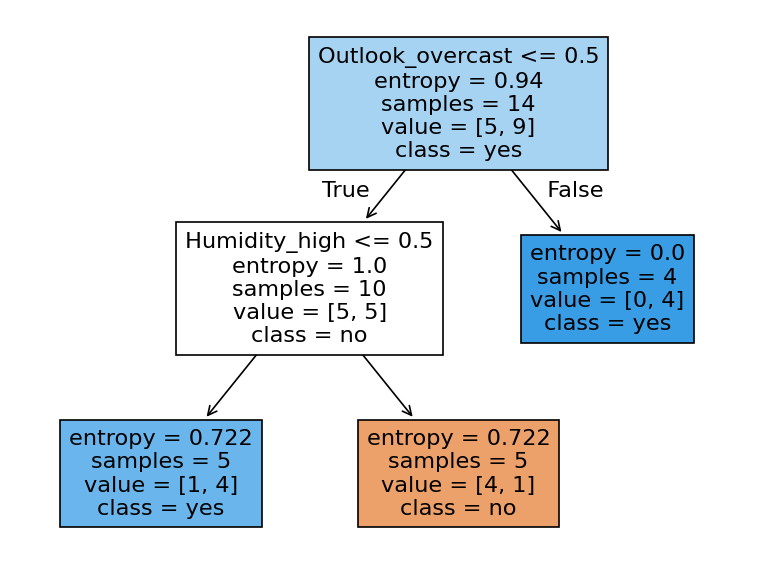

In [69]:
indeps = ['Outlook','Temperature','Humidity','Windy']
classifier = DecisionTreeClassifier(max_depth=2, criterion='entropy')

xs = pd.get_dummies(Data[indeps])
ys = Data['Play']

classifier.fit(xs,ys)

plt.figure(figsize=(8, 6), dpi=120)
tree.plot_tree(classifier,
               feature_names=list(xs.columns),
               class_names=list(np.unique(Data['Play'])),
               filled = True)

## Entropy vs. Gini: Comparative Insights in Practice  
Both entropy and Gini impurity serve the same role in guiding decision tree splits, and they usually lead to very similar results. Here are some comparative insights and practical considerations:

### Numerical Differences: 

Entropy (base 2) ranges from 0 to 1 for a binary node (and 0 to $\log_2 J$ for $J$ classes), whereas Gini ranges from 0 to $(1 - 1/J)$ (which is 0.5 for $J=2$, 0.667 for $J=3$, etc.) ([ML | Gini Impurity and Entropy in Decision Tree | GeeksforGeeks](https://www.geeksforgeeks.org/gini-impurity-and-entropy-in-decision-tree-ml/#:~:text=The%20range%20of%20the%20Gini,It%20is%20sensitive%20to%20the)) ([Decision Trees: Gini vs Entropy | Quantdare](https://quantdare.com/decision-trees-gini-vs-entropy/#:~:text=The%20Gini%20Index%20and%20the,Entropy%20have%20two%20main%20differences)). To compare them on the same scale, one could rescale Gini (for binary classes, $2 \times \text{Gini}$ ranges 0 to 1). When plotted as functions of the proportion of one class (say $p$ for positive class in binary), both entropy and Gini are smooth, convex curves that peak at $p=0.5$ and are zero at $p=0$ or $1$. The entropy curve is a bit steeper near the ends (due to the logarithm), but the difference is not dramatic ([Decision Trees: Gini vs Entropy | Quantdare](https://quantdare.com/decision-trees-gini-vs-entropy/#:~:text=,which%20are%20not%20very%20significant)). In effect, both criteria will rank splits in almost the same order because any split that significantly skews class probabilities will reduce both measures substantially.

### Computational Efficiency:

Gini impurity is easier to compute: it involves only squaring probabilities (or, effectively, computing class counts and sums of squares) and no logarithms. Entropy requires computing $p \log p$ for each class, which is slightly more computationally intensive ([ML | Gini Impurity and Entropy in Decision Tree | GeeksforGeeks](https://www.geeksforgeeks.org/gini-impurity-and-entropy-in-decision-tree-ml/#:~:text=It%20is%20sensitive%20to%20the,log%28c)) ([Decision Trees: Gini vs Entropy | Quantdare](https://quantdare.com/decision-trees-gini-vs-entropy/#:~:text=Image%3A%20Representation%20of%20Gini%20Index,and%20EntropyGini%20Index%20and%20Entropy)). In modern computers this difference is usually negligible for small numbers of classes, but in scenarios with very large numbers of classes or when building extremely large trees, the cumulative difference might make Gini a bit faster. Some benchmarking studies find that using Gini can reduce training time, especially on large datasets, on the order of, say, 5–20% depending on circumstances ([Decision Trees: Gini vs Entropy | Quantdare](https://quantdare.com/decision-trees-gini-vs-entropy/#:~:text=In%20the%20following%20graphs%2C%20the,axis%20is%20the%20training%20time)) ([Decision Trees: Gini vs Entropy | Quantdare](https://quantdare.com/decision-trees-gini-vs-entropy/#:~:text=As%20can%20be%20seen%2C%20the,more%20noticeable%20in%20larger%20datasets)). This is one reason the CART algorithm and scikit-learn default to Gini: it’s a slightly more lightweight computation.

### Theoretical Interpretations:

Entropy comes from information theory and has a clear interpretation in terms of information content (bits required to encode class information) ([Information gain (decision tree) - Wikipedia](https://en.wikipedia.org/wiki/Information_gain_(decision_tree)#:~:text=Basically%2C%20entropy%20is%20the%20measure,and%20the%20information%20value%20increases)). Information gain thus measures how much “information” about the class is gained by knowing the feature. Gini index, on the other hand, can be seen as measuring *purity* or diversity (it’s related to diversity indices used in ecology, and as noted earlier, to an error rate interpretation). Interestingly, Gini impurity is also a form of a generalized entropy (it corresponds to a *Tsallis entropy* of order 2 in physics terms) ([Decision tree learning - Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning#:~:text=The%20Gini%20impurity%20is%20also,usual%20entropy%20measure%20for%20decision)), so it’s conceptually a sibling of Shannon entropy. In essence, both are just different formulas to capture the notion of class impurity.

### Split Preferences:

There are some subtle differences in how the two criteria might bias the selection of splits:

- **Entropy (Information Gain)** has a slight bias toward splits that produce **more even partitions** of the data (it considers the log of probabilities, which weights changes in small probabilities somewhat more). It tends to more heavily penalize extreme class probability distributions. This means if one split yields one very pure small node and one large impure node, and another split yields two moderately impure but more balanced nodes, information gain might prefer the latter (because the overall entropy might be lower even if one branch is less pure, as long as it holds a lot of the data) ([ML | Gini Impurity and Entropy in Decision Tree | GeeksforGeeks](https://www.geeksforgeeks.org/gini-impurity-and-entropy-in-decision-tree-ml/#:~:text=It%20is%20the%20probability%20of,the%20class%20of%20an%20instance)). 

- **Gini** tends to be very similar, but some argue it’s slightly more sensitive to the **class distribution** in the nodes ([ML | Gini Impurity and Entropy in Decision Tree | GeeksforGeeks](https://www.geeksforgeeks.org/gini-impurity-and-entropy-in-decision-tree-ml/#:~:text=the%20number%20of%20classes,log%28c)). Gini impurity has a quadratic form which gives more weight to the largest class probabilities in a node. As a result, it might be slightly more sensitive to imbalances in class proportions. However, in many comparisons, the difference in chosen splits is minimal. In fact, for binary splits, one can show that if a split maximizes information gain, it often also maximizes Gini gain (since both are monotonic functions of the class counts for binary splits).

### Empirical Performance:

In terms of predictive accuracy of the final tree, it’s hard to declare a winner between entropy and Gini. Many empirical studies and examples have found that the difference in accuracy is not significant; one criterion might yield a slightly better tree on one dataset, and the other might win on another dataset, but overall they are comparably effective ([ML | Gini Impurity and Entropy in Decision Tree | GeeksforGeeks](https://www.geeksforgeeks.org/gini-impurity-and-entropy-in-decision-tree-ml/#:~:text=,circumstance%20and%20methodology%20being%20employed)) ([Decision Trees: Gini vs Entropy | Quantdare](https://quantdare.com/decision-trees-gini-vs-entropy/#:~:text=Image%3A%20Results%20comparison)). For instance, one might build two trees (one with each criterion) and find that they have somewhat different structures (especially if there are ties or very close gains at some nodes, the choice might diverge down the line), yet both trees often achieve similar accuracy on test data ([Decision Trees: Gini vs Entropy | Quantdare](https://quantdare.com/decision-trees-gini-vs-entropy/#:~:text=Finally%2C%20if%20we%20compare%20the,of%20the%20tree%20is%20different)). In one comparative experiment, using entropy vs Gini yielded trees with the same first split and overall predictive performance within a fraction of a percent of each other ([Decision Trees: Gini vs Entropy | Quantdare](https://quantdare.com/decision-trees-gini-vs-entropy/#:~:text=Image%3A%20Results%20comparison)) ([Decision Trees: Gini vs Entropy | Quantdare](https://quantdare.com/decision-trees-gini-vs-entropy/#:~:text=On%20the%20one%20hand%2C%20the,it%20is%20less%20computationally%20expensive)).

### Practical Default Choice:

The default choice in many implementations is Gini (as in CART and scikit-learn) mainly for historical and computational reasons, but if interpretability or information-theoretic reasoning is important, one might choose entropy. If you expect some features to have many distinct values, you might consider using *information gain ratio* (which is based on entropy) as C4.5 does, to avoid a bias that plain information gain has toward many-valued features (Gini has a similar bias too, though). But for most practical purposes, **both criteria will serve well**, and it’s often said that there is no single “best” impurity measure — the choice can depend on the specific dataset and context ([ML | Gini Impurity and Entropy in Decision Tree | GeeksforGeeks](https://www.geeksforgeeks.org/gini-impurity-and-entropy-in-decision-tree-ml/#:~:text=,circumstance%20and%20methodology%20being%20employed)).



## Another Example

In [70]:
Data2 = load_breast_cancer()
pd.DataFrame(Data2['data'])

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


DecisionTreeClassifier(criterion='entropy', max_depth=3)

0.9230769230769231

<Figure size 4800x2880 with 0 Axes>

[Text(0.5769230769230769, 0.875, 'worst concave points <= 0.145\nentropy = 0.953\nsamples = 426\nvalue = [159, 267]\nclass = benign'),
 Text(0.3076923076923077, 0.625, 'worst perimeter <= 107.75\nentropy = 0.405\nsamples = 285\nvalue = [23, 262]\nclass = benign'),
 Text(0.4423076923076923, 0.75, 'True  '),
 Text(0.15384615384615385, 0.375, 'mean texture <= 21.575\nentropy = 0.118\nsamples = 251\nvalue = [4, 247]\nclass = benign'),
 Text(0.07692307692307693, 0.125, 'entropy = 0.0\nsamples = 210\nvalue = [0, 210]\nclass = benign'),
 Text(0.23076923076923078, 0.125, 'entropy = 0.461\nsamples = 41\nvalue = [4, 37]\nclass = benign'),
 Text(0.46153846153846156, 0.375, 'worst texture <= 20.22\nentropy = 0.99\nsamples = 34\nvalue = [19, 15]\nclass = malignant'),
 Text(0.38461538461538464, 0.125, 'entropy = 0.0\nsamples = 12\nvalue = [0, 12]\nclass = benign'),
 Text(0.5384615384615384, 0.125, 'entropy = 0.575\nsamples = 22\nvalue = [19, 3]\nclass = malignant'),
 Text(0.8461538461538461, 0.625, 

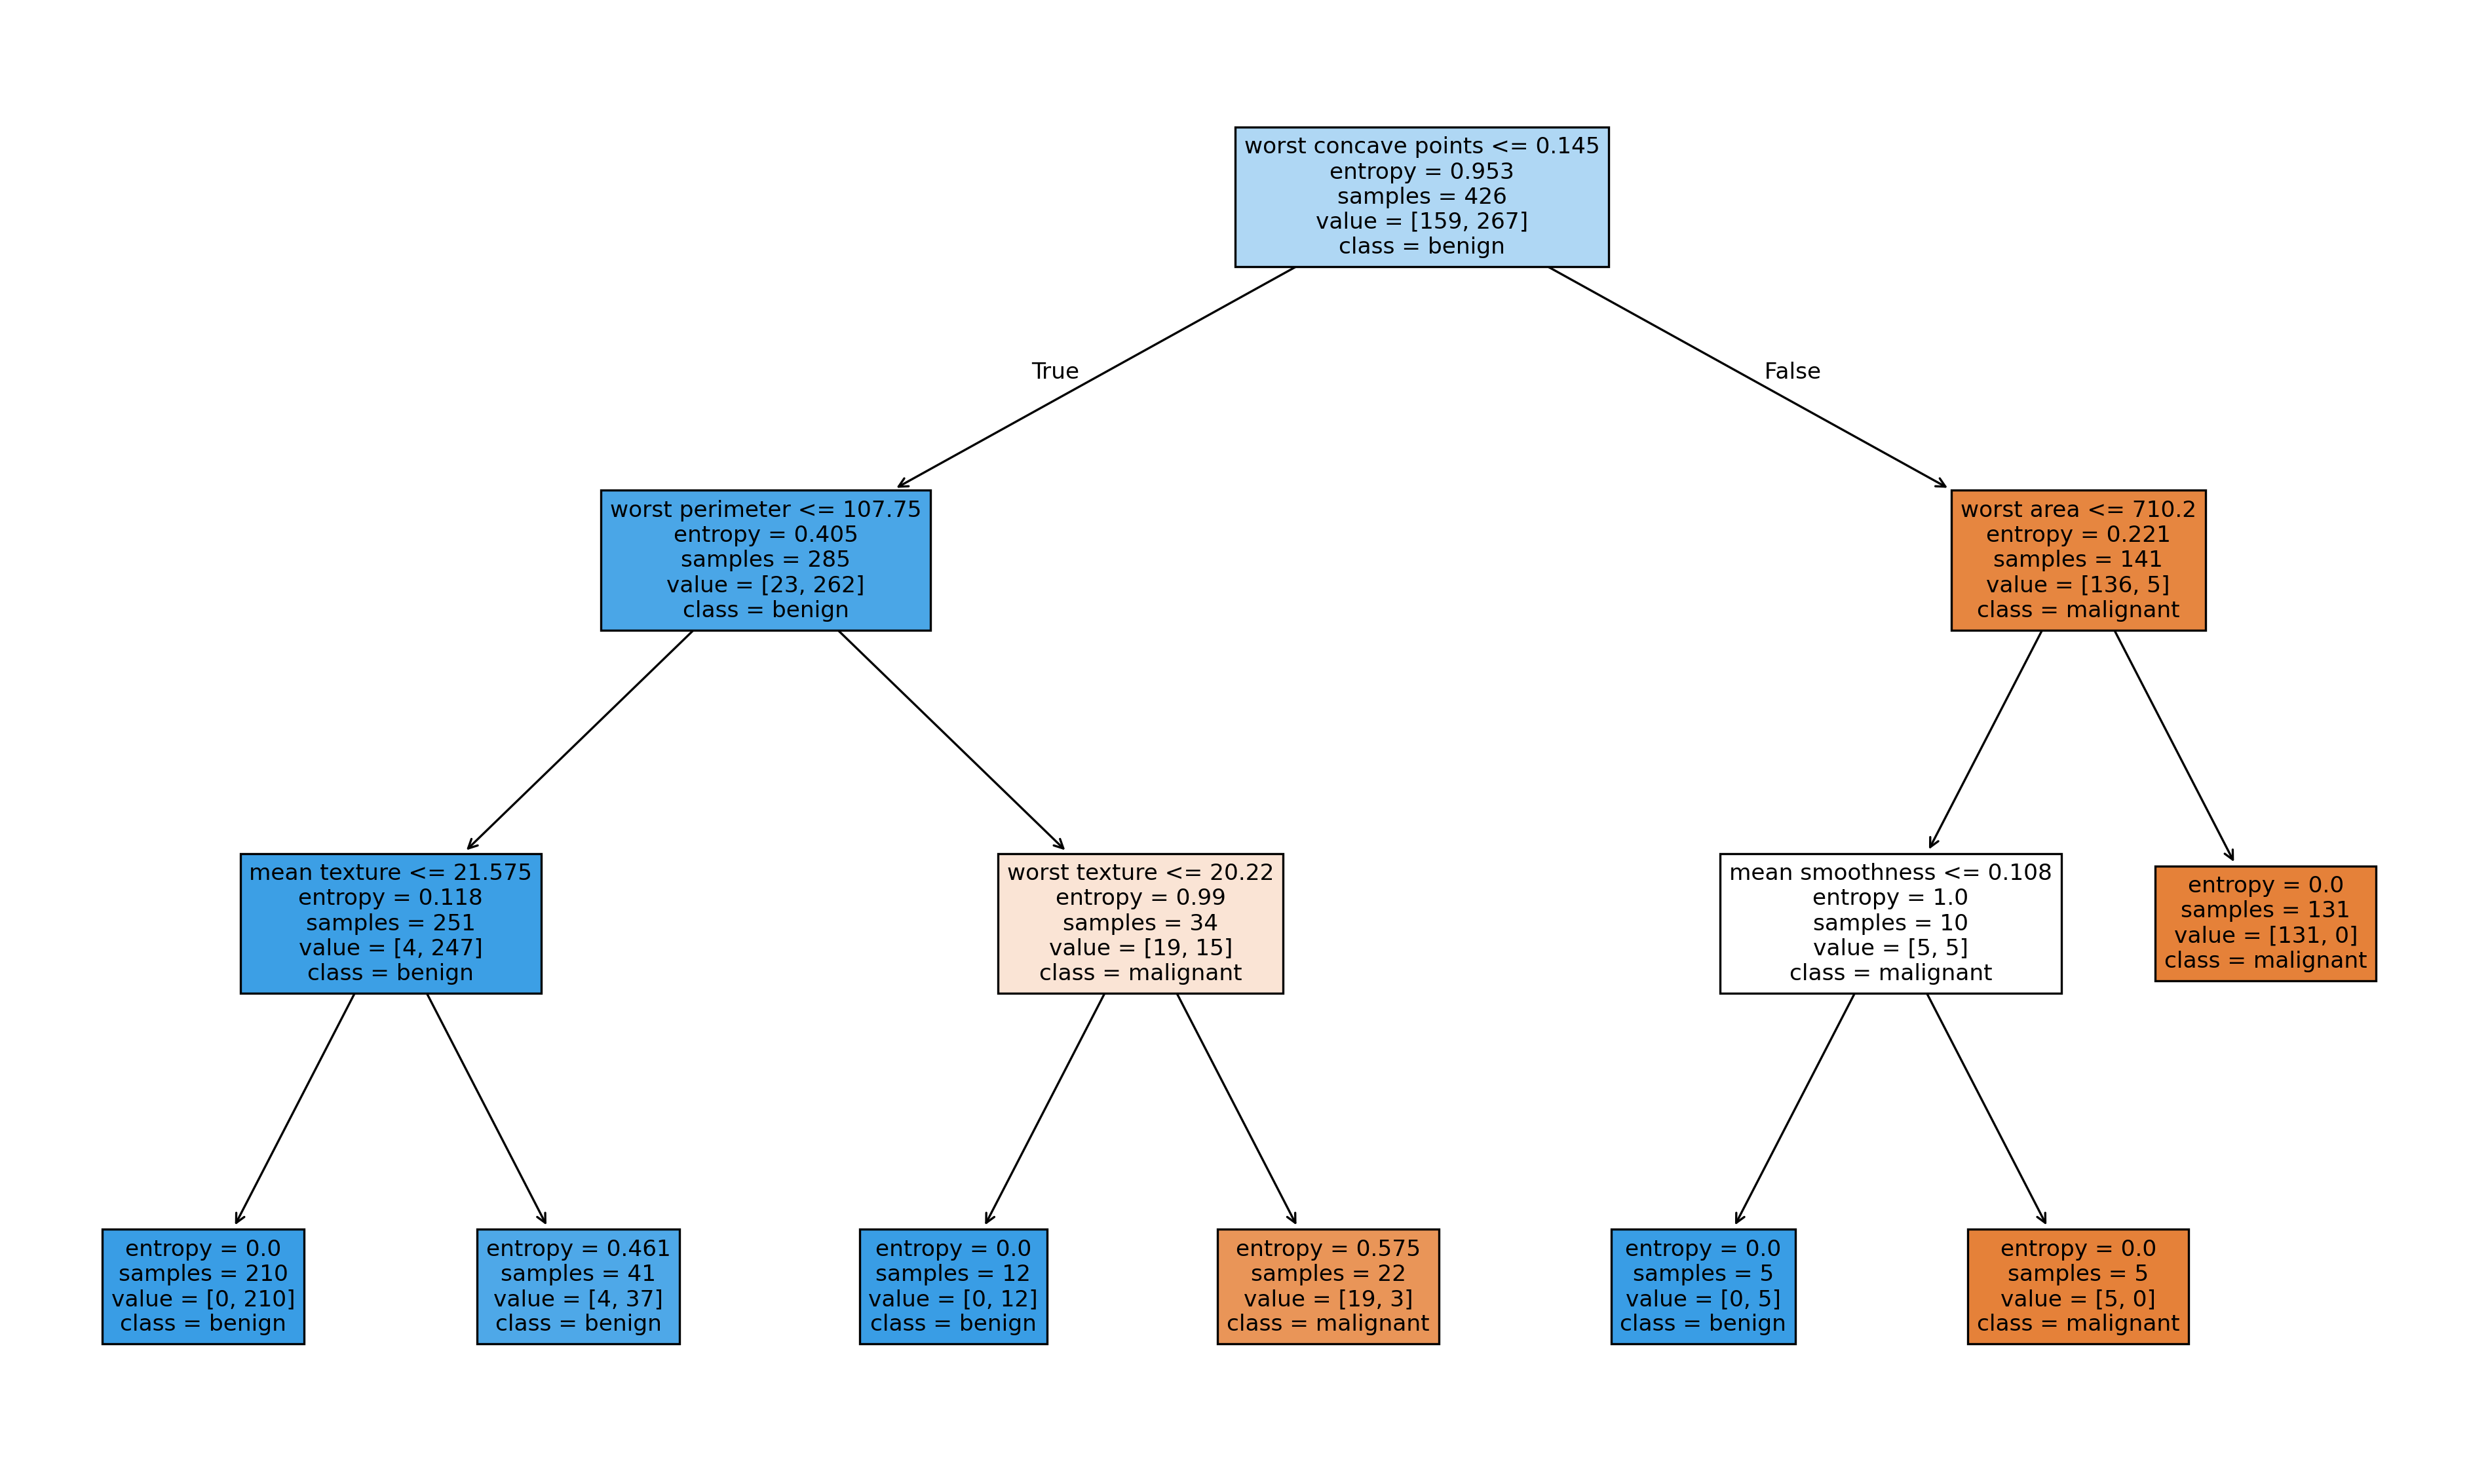

In [71]:
xs = Data2['data']
ys = Data2['target']

xtrain,xtest,ytrain,ytest = train_test_split(xs,ys)

model2 = DecisionTreeClassifier(max_depth=3, criterion='entropy')
model2.fit(xtrain,ytrain)
model2.score(xtest,ytest)

plt.figure(figsize=(20,12), dpi=240)
tree.plot_tree(model2,
               feature_names=list(Data2['feature_names']),
               class_names=list(Data2['target_names']),
               filled = True)

## Yet Another Example

In [72]:
Data3 = pd.read_csv('http://freakonometrics.free.fr/german_credit.csv')
Data3

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,24,2,3,1987,1,3,2,3,...,4,1,21,3,1,1,2,2,1,1
996,0,1,24,2,0,2303,1,5,4,3,...,1,1,45,3,2,1,3,1,1,1
997,0,4,21,4,0,12680,5,5,4,3,...,4,4,30,3,3,1,4,1,2,1
998,0,2,12,2,3,6468,5,1,2,3,...,1,4,52,3,2,1,4,1,2,1


DecisionTreeClassifier(criterion='entropy', max_depth=4)

<Figure size 8640x2880 with 0 Axes>

[Text(0.5, 0.9, 'Account Balance <= 2.5\nentropy = 0.881\nsamples = 1000\nvalue = [300, 700]\nclass = Not Credible'),
 Text(0.25, 0.7, 'Duration of Credit (month) <= 22.5\nentropy = 0.99\nsamples = 543\nvalue = [240, 303]\nclass = Not Credible'),
 Text(0.375, 0.8, 'True  '),
 Text(0.125, 0.5, 'Payment Status of Previous Credit <= 1.5\nentropy = 0.931\nsamples = 306\nvalue = [106, 200]\nclass = Not Credible'),
 Text(0.0625, 0.3, 'Purpose <= 7.0\nentropy = 0.811\nsamples = 28\nvalue = [21, 7]\nclass = Credible'),
 Text(0.03125, 0.1, 'entropy = 0.634\nsamples = 25\nvalue = [21, 4]\nclass = Credible'),
 Text(0.09375, 0.1, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]\nclass = Not Credible'),
 Text(0.1875, 0.3, 'Duration of Credit (month) <= 11.5\nentropy = 0.888\nsamples = 278\nvalue = [85, 193]\nclass = Not Credible'),
 Text(0.15625, 0.1, 'entropy = 0.669\nsamples = 80\nvalue = [14, 66]\nclass = Not Credible'),
 Text(0.21875, 0.1, 'entropy = 0.942\nsamples = 198\nvalue = [71, 127]\nclass = 

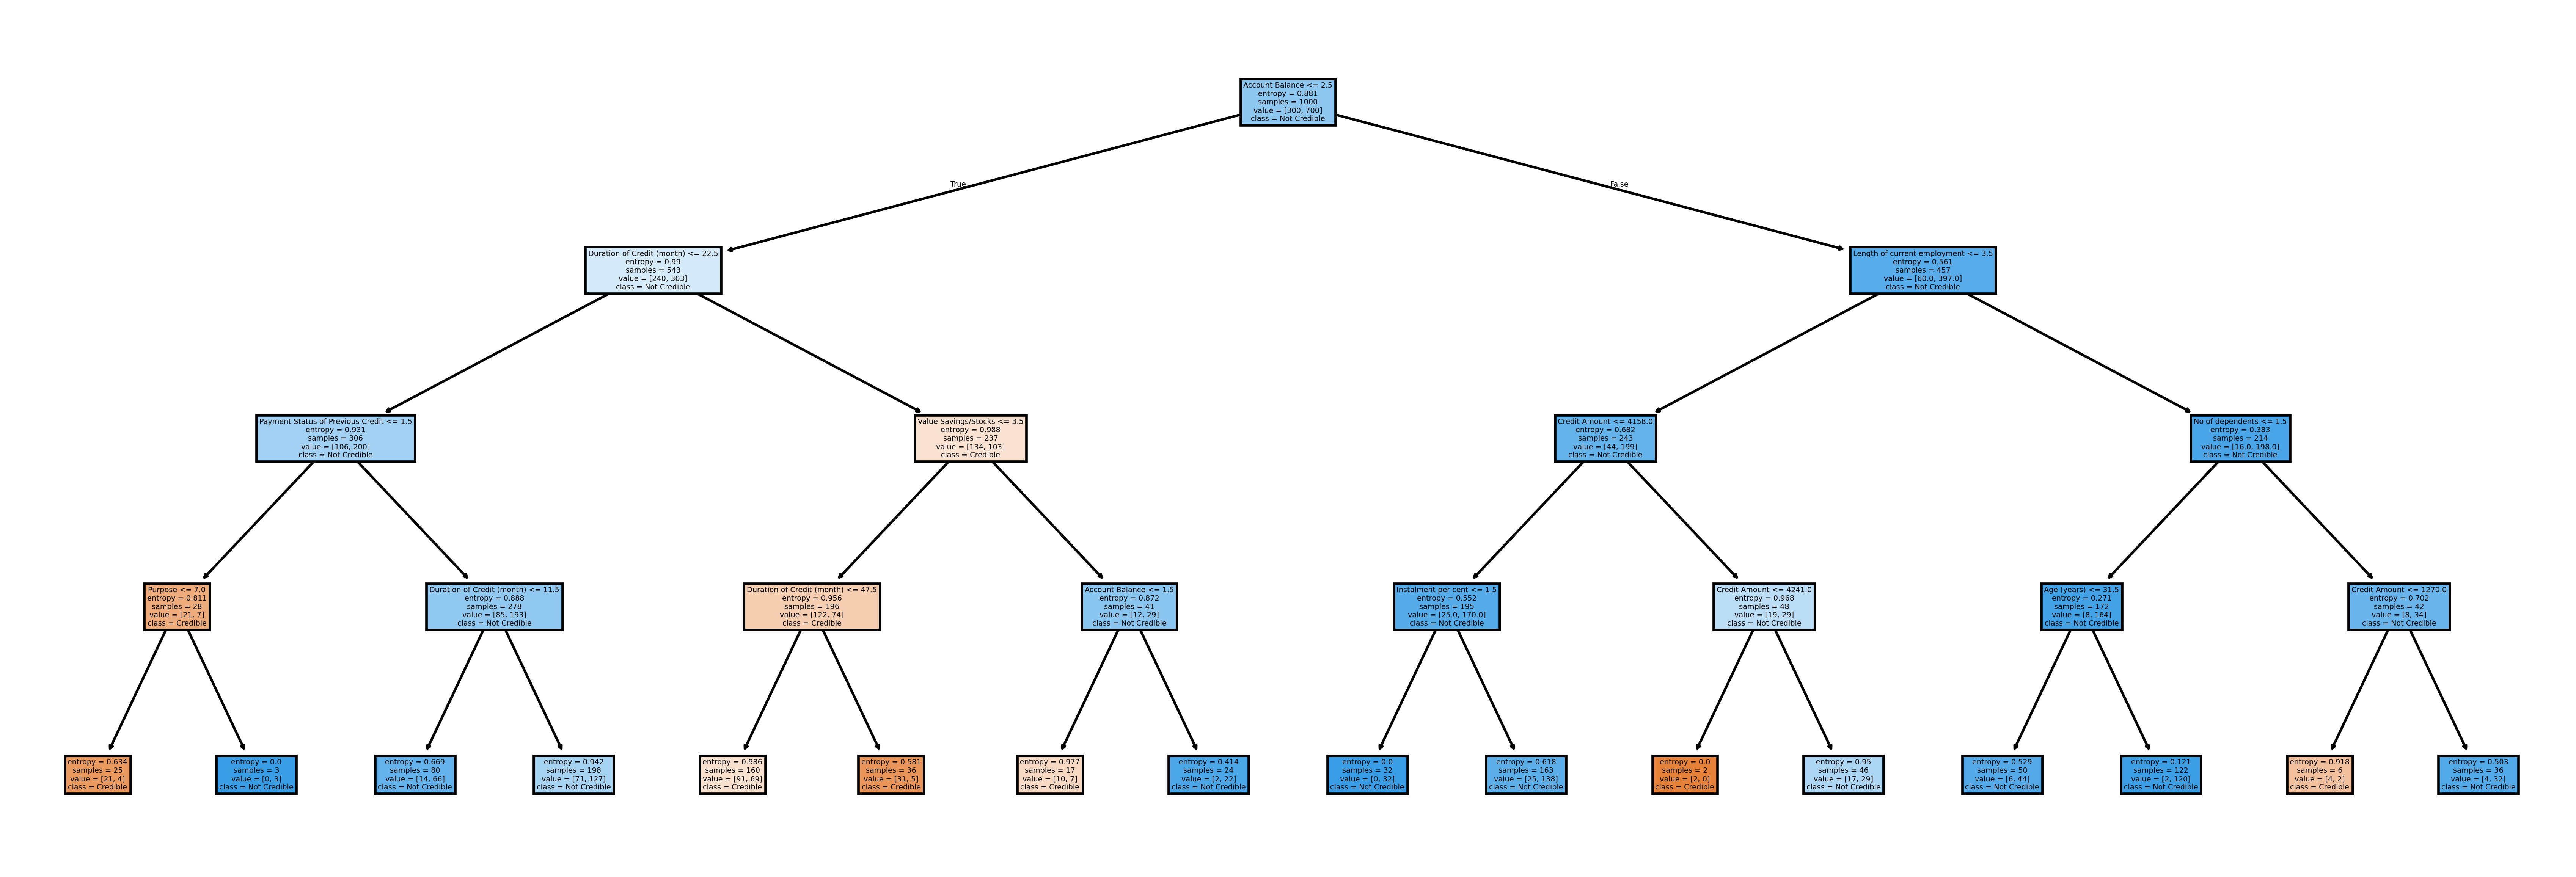

In [73]:
ys = Data3['Creditability']
xs = Data3.iloc[:,1:]

X_train, X_test, y_train, y_test = train_test_split(xs,ys,train_size=0.5)

model3 = DecisionTreeClassifier(max_depth=4,criterion='entropy')
model3.fit(xs,ys)

plt.figure(figsize=(18,6),dpi=480)
tree.plot_tree(model3,filled=True,feature_names=list(xs.columns),class_names=['Credible','Not Credible'])